# Importing libraries and setting constants

In [29]:
import numpy as np
import pandas as pd
import os
import csv
import tensorflow
from IPython.display import Audio
import librosa
import librosa.display
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from tensorflow.keras.optimizers import Adam #general and commonly applicable optimizer
from keras.layers import Conv1D, BatchNormalization, Activation, Input, Dense, Bidirectional, LSTM, Dropout, TimeDistributed, Lambda
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
#from livelossplot import PlotLossesKeras
from tensorflow.keras.metrics import Recall, Precision
import keras
import keras.backend as K
import time
import matplotlib.pyplot as plt
%matplotlib inline

train_path = "./train/audio/" 
val_text = "./train/validation_list.txt"
test_text = "./train/testing_list.txt"

ModuleNotFoundError: No module named 'livelossplot'

# Data loading and preparation

In [28]:
classes = os.listdir(train_path)
classes.remove("_background_noise_")

print(classes)

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']


004ae714_nohash_0.wav


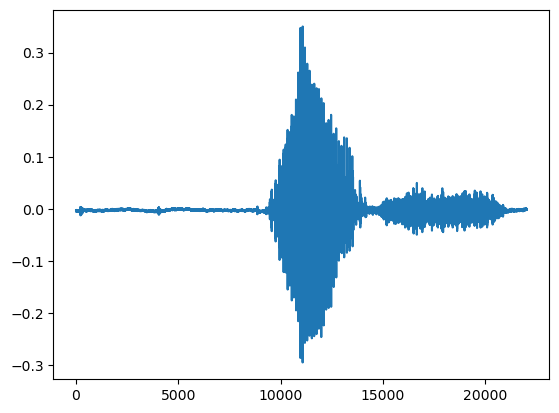

In [6]:
sample_audio_file = os.listdir(train_path+"yes")[0]
print(sample_audio_file)

x, r = librosa.load(train_path+"yes/{}".format(sample_audio_file))
plt.plot(x)

Audio(x, rate=r)

In [7]:
def make_spec(file, file_dir=train_path, flip=False, ps=False, st = 4):
    """
    create a melspectrogram from the amplitude of the sound
    
    Args:
        file (str): filename
        file_dir (str): directory path
        flip (bool): reverse time axis
        ps (bool): pitch shift
        st (int): half-note steps for pitch shift
    Returns:
        np.array with shape (122,85) (time, freq)
    """
    
    sig, sr = librosa.load(file_dir+file, sr=16000)
    
    if len(sig) < 16000: #pad shorter than 1 sec audio with ramp to zero
        sig = np.pad(sig, (0,16000-len(sig)), "linear_ramp")
        
    if ps:
        sig = librosa.effects.pitch_shift(sig, rate, st)
        
    D = librosa.amplitude_to_db(librosa.stft(sig[:16000], 
                                             n_fft=512, 
                                             hop_length=128,
                                             center=False),
                               ref=np.max)
    S = librosa.feature.melspectrogram(S=D, n_mels=85).T
    
    if flip:
        S = np.flipud(S)
    
    return S.astype(np.float32)

C:\Users\48695\AppData\Local\Temp\ipykernel_7100\189709540.py:23: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(sig[:16000],
C:\Users\48695\AppData\Local\Temp\ipykernel_7100\189709540.py:23: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(sig[:16000],


(122, 85)

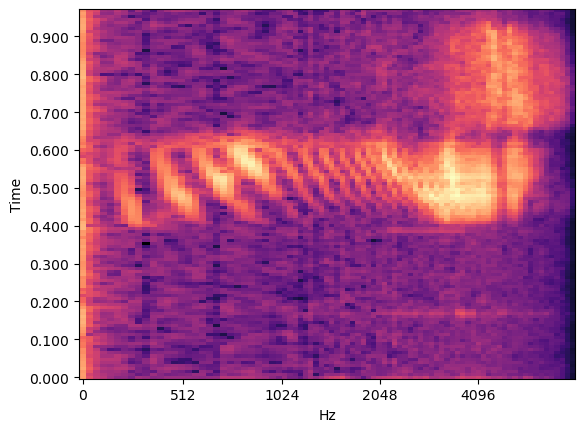

In [8]:
librosa.display.specshow(make_spec("yes/{}".format(sample_audio_file)),
                         x_axis="mel",
                         fmax=8000,
                         y_axis="time",
                         sr=16000,
                         hop_length=128)
make_spec("yes/{}".format(sample_audio_file)).shape

In [9]:
def create_sets(file_list=training_list):
    X_array = np.zeros([len(file_list), 122, 85])
    y_array = np.zeros([len(file_list)])
    for ind, file in enumerate(file_list):
        if ind%2000 == 0:
            print("{} done!".format(ind))
        try:
            X_array[ind] = make_spec(file)
        except ValueError:
            print(ind, file, ValueError)
        y_array[ind] = classes.index(file.rsplit('/')[0])
    print("All Done!")
    return X_array, y_array

In [10]:
X_train, y_train = create_sets()

0 done!


C:\Users\48695\AppData\Local\Temp\ipykernel_7100\189709540.py:23: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(sig[:16000],


2000 done!
4000 done!
6000 done!
8000 done!
10000 done!
12000 done!
14000 done!
16000 done!
18000 done!
20000 done!
22000 done!
24000 done!
26000 done!
28000 done!
30000 done!
32000 done!
34000 done!
36000 done!
38000 done!
40000 done!
42000 done!
44000 done!
46000 done!
48000 done!
50000 done!
All Done!


In [12]:
np.save("./X_train.npy", np.expand_dims(X_train, -1)+1.3) #Normalizing using mean
np.save("./y_train.npy", y_train.astype(np.int64))
print("Saved!")

Saved!


In [13]:
X_val, y_val = create_sets(file_list=validation_list)

0 done!


C:\Users\48695\AppData\Local\Temp\ipykernel_7100\189709540.py:23: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(sig[:16000],


2000 done!
4000 done!
6000 done!
All Done!


In [14]:
np.save('./X_val.npy', np.expand_dims(X_val, -1)+1.3) #Normalization using mean value
np.save('./y_val.npy', y_val.astype(np.int64))
print("Saved!")

Saved!


In [16]:
X_train = np.load("./X_train.npy")
y_train = np.load("./y_train.npy")

X_val = np.load("./X_val.npy")
y_val = np.load("./y_val.npy")

In [20]:
X_train = X_train.reshape((-1, X_train.shape[1], X_train.shape[2]))
X_val = X_val.reshape((-1, X_val.shape[1], X_val.shape[2]))

In [24]:
NB_CLASSES = len(classes)

In [25]:
y_train = to_categorical(y_train, num_classes=NB_CLASSES)
y_val = to_categorical(y_val, num_classes=NB_CLASSES)

# Transformer model